```
Trong mô hình IBM 1, trật tự từ được bỏ qua để làm đơn giản mô hình. Chỉ cần các phép gióng từ là tương đương,
không quan trọng vị trí của từ đó ở đâu trong câu nguồn hoặc câu kết quả.
Cho nên 3 phép gióng hàng sau là tương tự nhau:

Câu nguồn: je mange du jambon
Câu kết quả: i eat some ham
Phép gióng hàng: (0,0) (1,1) (2,2) (3,3)

Câu nguồn: je mange du jambon
Câu kết quả: some ham eat i
Phép gióng hàng: (0,2) (1,3) (2,1) (3,1)

Câu nguồn: du jambon je mange
Câu kết quả: eat i some ham
Phép gióng hàng: (0,3) (1,2) (2,0) (3,1)
```

In [ ]:
from collections import defaultdict
from nltk.translate import AlignedSent  #Trả về 1 đối tượng là các câu đã được gióng hàng
from nltk.translate import Alignment
from nltk.translate import IBMModel     #Lớp trừu tượng của IBMModel
from nltk.translate.ibm_model import Counts  #Chứa biến đếm của các tham số trong lúc training
import warnings

In [ ]:
class IBMModel1(IBMModel): #Mô hình dịch ngữ nghĩa bỏ qua trật tự từ 

    def __init__(self, sentence_aligned_corpus, iterations, probability_tables=None):
        """
        Huấn luyện dựa trên tập các câu đã được gióng hàng và tạo ra 
        1 mô hình dịch ngữ nghĩa
        
        Translation direction is from ``AlignedSent.mots`` to
        ``AlignedSent.words``.

        : Tham số sentence_aligned_corpus: tập hợp các câu đã được gióng hàng.
        : Kiểu tham số: list
        
        : Tham số iterations: Số lần lặp để chạy thuật toán training.
        : Kiểu tham số: int

        : Tham số probability_tables: là tham số tùy chọn, dùng để truyền vào 1 
        giá trị xác suất. Nếu không được truyền giá trị vào thì xác suất sẽ được
        gán thành phân phối đều, hoặc 1 giá trị hợp lý khác. Nếu được chỉ định,
        tất cả các mục sau đây phải có:
              ``translation_table``, ``alignment_table``.
        : Kiểu tham số: dict[str]: object
        """
        super(IBMModel1, self).__init__(sentence_aligned_corpus)

        if probability_tables is None:
            self.set_uniform_probabilities(sentence_aligned_corpus)
        else:
            # Đặt giá trị xác suất được người dùng định nghĩa
            self.translation_table = probability_tables["translation_table"]

        for n in range(0, iterations): #Huấn luyện các cặp câu đã được gióng hàng
            self.train(sentence_aligned_corpus)

        self.align_all(sentence_aligned_corpus)

    def set_uniform_probabilities(self, sentence_aligned_corpus): #Khởi tạo các bảng xác suất cho phân phối đều
        initial_prob = 1 / len(self.trg_vocab)
        if initial_prob < IBMModel.MIN_PROB: #MIN_PROB = 1e-12
            warnings.warn(
                "Target language vocabulary is too large ("
                + str(len(self.trg_vocab))
                + " words). "
                "Results may be less accurate."
            )

        for t in self.trg_vocab:
            self.translation_table[t] = defaultdict(lambda: initial_prob)


    def train(self, parallel_corpus):
        counts = Counts()
        for aligned_sentence in parallel_corpus:
            #print("aligned_sentence = " + str(aligned_sentence))
            trg_sentence = aligned_sentence.words
            #print("trg_sentence = " + str(trg_sentence))
            src_sentence = [None] + aligned_sentence.mots
            #print("src_sentence = " + str(src_sentence))

            # E step (a): Tính toán các yếu tố chuẩn hóa để đếm trọng số
            total_count = self.prob_all_alignments(src_sentence, trg_sentence)

            # E step (b): Thu thập các biến đếm
            for t in trg_sentence:
                for s in src_sentence:
                    count = self.prob_alignment_point(s, t)
                    normalized_count = count / total_count[t]
                    counts.t_given_s[t][s] += normalized_count
                    counts.any_t_given_s[s] += normalized_count

        # M step: Cập nhật giá trị xác suất với ước tính khả năng đúng cao nhất
        self.maximize_lexical_translation_probabilities(counts)


    def prob_all_alignments(self, src_sentence, trg_sentence):
        """
        Tính toán xác suất của tất cả các phép gióng hàng có thể có,
        thể hiện dưới dạng phân phối biên trên các từ mục tiêu

        Mỗi mục trong giá trị trả về thể hiện sự đóng góp vào tổng xác suất
        gióng hàng của từ mục tiêu t.

        Để có được xác suất (alignment | src_sentence, trg_sentence), 
        chỉ cần tổng hợp các mục trong giá trị trả về.

        :Giá trị trả về: Xác suất của t với mọi s thuộc ``src_sentence``
        :rtype: dict(str): float
        """
        alignment_prob_for_t = defaultdict(lambda: 0.0)
        for t in trg_sentence:
            for s in src_sentence:
                alignment_prob_for_t[t] += self.prob_alignment_point(s, t)
        return alignment_prob_for_t


    def prob_alignment_point(self, s, t):
        """
        Xác suất để từ ``t`` trong câu kết quả được gióng với từ ``s``
        trong câu nguồn
        """
        return self.translation_table[t][s]


    def prob_t_a_given_s(self, alignment_info):
        """
        Xác suất từ câu kết quả và phép gióng hàng từ câu nguồn
        """
        prob = 1.0

        for j, i in enumerate(alignment_info.alignment):
            if j == 0:
                continue  # skip the dummy zeroeth element
            trg_word = alignment_info.trg_sentence[j]
            src_word = alignment_info.src_sentence[i]
            prob *= self.translation_table[trg_word][src_word]

        return max(prob, IBMModel.MIN_PROB)


    def align_all(self, parallel_corpus):
        for sentence_pair in parallel_corpus:
            self.align(sentence_pair)


    def align(self, sentence_pair):
        """
        Xác định phép gióng hàng tốt nhất cho 1 cặp câu từ kho văn bản đã được 
        mô hình huấn luyện 

        Phép gióng hàng tốt nhất sẽ được đặt trong tham số 'sentence_pair' 
        khi phương thức trả về.

        :tham số sentence_pair: 1 câu trong ngôn ngữ nguồn và câu tương ứng của nó
        ở ngôn ngữ kết quả
        :kiểu sentence_pair: AlignedSent
        """
        best_alignment = []

        for j, trg_word in enumerate(sentence_pair.words):
            # Initialize trg_word to align with the NULL token
            best_prob = max(self.translation_table[trg_word][None], IBMModel.MIN_PROB)
            best_alignment_point = None
            for i, src_word in enumerate(sentence_pair.mots):
                align_prob = self.translation_table[trg_word][src_word]
                if align_prob >= best_prob:  # prefer newer word in case of tie
                    best_prob = align_prob
                    best_alignment_point = i

            best_alignment.append((j, best_alignment_point))

        sentence_pair.alignment = Alignment(best_alignment)

In [ ]:
bitext = [] #Khởi tạo 1 danh sách rỗng
#Lần lượt thêm các phép gióng hàng vào danh sách vừa khởi tạo
bitext.append(AlignedSent(['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small']))
bitext.append(AlignedSent(['das', 'haus', 'ist', 'ja', 'groß'], ['the', 'house', 'is', 'big']))
bitext.append(AlignedSent(['das', 'buch', 'ist', 'ja', 'klein'], ['the', 'book', 'is', 'small']))
bitext.append(AlignedSent(['das', 'haus'], ['the', 'house']))
bitext.append(AlignedSent(['das', 'buch'], ['the', 'book']))
bitext.append(AlignedSent(['ein', 'buch'], ['a', 'book']))

# Huấn luyện mô hình
ibm1 = IBMModel1(bitext, 5)


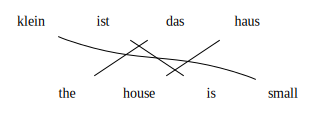

In [ ]:
bitext[0]

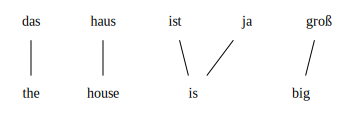

In [ ]:
bitext[1]

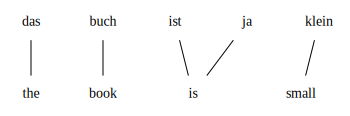

In [ ]:
bitext[2]

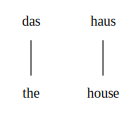

In [ ]:
bitext[3]

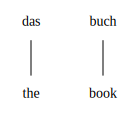

In [ ]:
bitext[4]

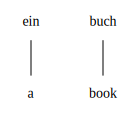

In [ ]:
bitext[5]

In [ ]:
print("ibm1.translation_table['buch']['book']") #Xác suất để từ 'buch' tương ứng với từ 'book'
print('{0:.3f}'.format(ibm1.translation_table['buch']['book']))
print("ibm1.translation_table['das']['book']")
print('{0:.3f}'.format(ibm1.translation_table['das']['book']))
print("ibm1.translation_table['buch'][None]")
print('{0:.3f}'.format(ibm1.translation_table['buch'][None]))
print("ibm1.translation_table['ja'][None]")
print('{0:.3f}'.format(ibm1.translation_table['ja'][None]))

ibm1.translation_table['buch']['book']
0.889
ibm1.translation_table['das']['book']
0.062
ibm1.translation_table['buch'][None]
0.113
ibm1.translation_table['ja'][None]
0.073


In [ ]:
test_sentence = bitext[2]
print(test_sentence.words)

['das', 'buch', 'ist', 'ja', 'klein']


In [ ]:
print(test_sentence.mots)

['the', 'book', 'is', 'small']


In [ ]:
print(test_sentence.alignment)

0-0 1-1 2-2 3-2 4-3
